# Dynamic Estimation Introduction

Dynamic estimation is a method to align data and model predictions for time-varying systems. Dynamic models and data rarely align perfectly because of several factors including limiting assumptions that were used to build the model, incorrect model parameters, data that is corrupted by measurement noise, instrument calibration problems, measurement delay, and many other factors. All of these factors may cause mismatch between predicted and measured values.

The focus of this section is to develop methods with dynamic optimization to realign model predictions and measured values with the goal of estimating states and parameters. Another focus of this section is to understand model structure that can lead to poorly observable parameters and determine confidence regions for parameter estimates. The uncertainty analysis serves to not only predict unmeasured quantities but also to relate a confidence in those predictions.

Dynamic estimation algorithms optimize model predictions over a prior time horizon of measurements. These state and parameter values may then be used to update the model for improved forward prediction in time to anticipate future dynamic events. The updated model allows dynamic optimization or control actions with increased confidence.

### Example 1

Estimate the parameter $k$ in the exponential decay equation:

$$\frac{dx}{dt} = -kx$$

by minimizing the error between the predicted and measured $x$ values. 

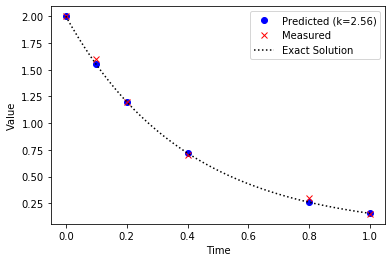

In [3]:
from gekko import GEKKO

t_data = [0, 0.1, 0.2, 0.4, 0.8, 1]
x_data = [2.0,  1.6,  1.2, 0.7,  0.3,  0.15]

m = GEKKO(remote=False)
m.time = t_data
x = m.CV(value=x_data); x.FSTATUS = 1  # fit to measurement
k = m.FV(); k.STATUS = 1               # adjustable parameter
m.Equation(x.dt()== -k * x)            # differential equation

m.options.IMODE = 5   # dynamic estimation
m.options.NODES = 5   # collocation nodes
m.solve(disp=False)   # display solver output
k = k.value[0]

import numpy as np
import matplotlib.pyplot as plt  # plot solution
plt.plot(m.time,x.value,'bo',\
         label='Predicted (k='+str(np.round(k,2))+')')
plt.plot(m.time,x_data,'rx',label='Measured')
# plot exact solution
t = np.linspace(0,1); xe = 2*np.exp(-k*t)
plt.plot(t,xe,'k:',label='Exact Solution')
plt.legend()
plt.xlabel('Time'), plt.ylabel('Value')
plt.show()

The approach can also be extended to multiple data sets and when the experimental values are at different times.

In [4]:
from gekko import GEKKO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# data set 1
t_data1 = [0.0,  0.1,  0.2, 0.4, 0.8, 1.00]
x_data1 = [2.0,  1.6,  1.2, 0.7, 0.3, 0.15]

# data set 2
t_data2 = [0.0,  0.15, 0.25, 0.45, 0.85, 0.95]
x_data2 = [3.6,  2.25, 1.75, 1.00, 0.35, 0.20]

# combine with dataframe join
data1 = pd.DataFrame({'Time':t_data1,'x1':x_data1})
data2 = pd.DataFrame({'Time':t_data2,'x2':x_data2})
data1.set_index('Time', inplace=True)
data2.set_index('Time', inplace=True)
data = data1.join(data2,how='outer')
print(data.head())

# indicate which points are measured
z1 = (data['x1']==data['x1']).astype(int) # 0 if NaN
z2 = (data['x2']==data['x2']).astype(int) # 1 if number

# replace NaN with any number (0)
data.fillna(0,inplace=True)

m = GEKKO(remote=False)

# measurements
xm = m.Array(m.Param,2)
xm[0].value = data['x1'].values
xm[1].value = data['x2'].values

# index for objective (0=not measured, 1=measured)
zm = m.Array(m.Param,2)
zm[0].value=z1
zm[1].value=z2

m.time = data.index
x = m.Array(m.Var,2)                   # fit to measurement
x[0].value=x_data1[0]; x[1].value=x_data2[0]

k = m.FV(); k.STATUS = 1               # adjustable parameter
for i in range(2):
    m.free_initial(x[i])               # calculate initial condition
    m.Equation(x[i].dt()== -k * x[i])  # differential equations
    m.Minimize(zm[i]*(x[i]-xm[i])**2)  # objectives

m.options.IMODE = 5   # dynamic estimation
m.options.NODES = 2   # collocation nodes
m.solve(disp=True)    # solve
k = k.value[0]
print('k = '+str(k))

# plot solution
plt.plot(m.time,x[0].value,'b.--',label='Predicted 1')
plt.plot(m.time,x[1].value,'r.--',label='Predicted 2')
plt.plot(t_data1,x_data1,'bx',label='Measured 1')
plt.plot(t_data2,x_data2,'rx',label='Measured 2')
plt.legend(); plt.xlabel('Time'); plt.ylabel('Value')
plt.xlabel('Time');
plt.show()

       x1    x2
Time           
0.00  2.0  3.60
0.10  1.6   NaN
0.15  NaN  2.25
0.20  1.2   NaN
0.25  NaN  1.75


AttributeError: 'GEKKO' object has no attribute 'free_initial'

### Example 2

Estimate the parameter $a, b, c, d$ in the differential equation:

$$\frac{d^3x}{dt^3} = a\frac{d^2x}{dt^2}+b\frac{dx}{dt}+c x+d$$

by minimizing the error between the predicted and measured $x$ values. The $x$ values are measured at the following time intervals. Use an initial condition of $x=2$ that matches the data. Create new states $y=\frac{dx}{dt}$ and $z=\frac{dy}{dt}$ for the higher order derivative terms.

$$\frac{dx}{dt} = y$$
$$\frac{dy}{dt} = z$$
$$\frac{dz}{dt} = az+by+cx+d$$


-37.699565828 -2310.5055552 -6173.4615908 123.00783964


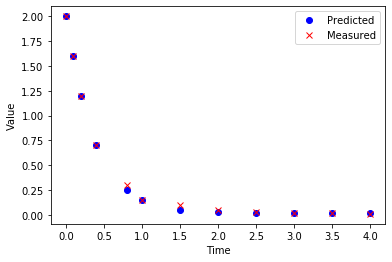

In [ ]:
from gekko import GEKKO

t_data = [0,0.1,0.2,0.4,0.8,1,1.5,2,2.5,3,3.5,4]
x_data = [2.0,1.6,1.2,0.7,0.3,0.15,0.1,\
          0.05,0.03,0.02,0.015,0.01]

m = GEKKO()
m.time = t_data

# states
x = m.CV(value=x_data); x.FSTATUS = 1  # fit to measurement
y,z = m.Array(m.Var,2,value=0)

# adjustable parameters
a,b,c,d = m.Array(m.FV,4)
a.STATUS=1; b.STATUS=1; c.STATUS=1; d.STATUS=1

# differential equation
#      Original:  x''' = a*x'' + b x' + c x + d
#      Transform: y = x'
#                 z = y'
#                 z' = a*z + b*y + c*x + d
m.Equations([y==x.dt(),z==y.dt()])
m.Equation(z.dt()==a*z+b*y+c*x+d) # differential equation

m.options.IMODE = 5   # dynamic estimation
m.options.NODES = 3   # collocation nodes
m.solve(disp=False)   # display solver output
print(a.value[0],b.value[0],c.value[0],d.value[0])

import matplotlib.pyplot as plt  # plot solution
plt.plot(m.time,x.value,'bo',label='Predicted')
plt.plot(m.time,x_data,'rx',label='Measured')
plt.legend()
plt.xlabel('Time'), plt.ylabel('Value')
plt.show()
